In [1]:
%pylab
import seaborn as sns
%load_ext autoreload
%autoreload 2
from random import choice as randsample
%matplotlib inline
import statespace as st
import pandas as pd

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


State space analysis 
====================

This notebook demonstrates how to perform a state space analysis on MEG data Mante et al style. I start by giving an example on fake data and then showing the results on Anne's MEG data. The later ones are not computed in the notebook and only the results are shown (for time/space reasons).

How does the state space analysis work?
-------------------------------------

The goal of the state space analysis is to find a representation of a high dimensional data set in a few meaningful dimensions. To find these dimensions it uses a regression model that predicts the physiological response we are interested in based on regressors (e.g. experimental conditions). The regression model is performed separately for each unit (here MEG channel) and timestep. The trick is now to combine the betas of the regression model across units such that we obtain # of time points x # conditions vectors with length # of units. This vector encodes how much each channel contributes to the activity in a specific condition. We can therefore use it to project the high dimensional activity into a 1D space that is related to a particular condition (e.g. meaningful). Do this for 2 conditions and you obtain nice plots. Along the way Mante et al. perform some cleaning of the data based on PCA.

Here comes everything I just described in a little more detail.

Step 1: Regression analysis
---------------------------

For each unit (channel/sensor/whatever) predict it's z-scored activation from a set of regressors. This gives a vector of size $N_{coef}$ for each unit and timestep, let's call this vector $\beta_{i,t}$ and $i$ indexes units and $t$ indexes time.

Step 2: PCA based population cleaning
-------------------------------------

   - For each unit construct average response vectors in all conditions.
   - z-score condition averages and smooth them 
   - Define vector $x_{x,t}$ that contains the value of all units in condition $c$ at time $t$.$x_{c,t}$ is of size $N_{units}$
   - Build matrix $X$ of size $N_{unit} x (N_{condition} * T)$, where the columns contain the concatenaed population averages. Concatenated across conditions and time that is. Run PCA on $X$ and collect the first 12 PCs in vectors $v_a$ where $a$ indexes the PCs. Each $v_a$ is of size $N_{unit}$.
   -  Project matrix $X$ onto the first 12 components. 

Step 3: Projection into regression subspace
-------------------------------------------

   - We start by rearranging the $\beta_{i,t}$'s into vectors that contain the regression weights of one condition and time point for all units: $\beta_{i,t} \rightarrow \beta_{v,t}$.
   - Now denoise these vectors using the PCA projection, this works since $\beta_{v,t}$ has size $N_{units}$.
   - Now find for each $v$ the maximum over time in each the vector $\beta_{v,t}$. Thies yields one vector $\beta_{v}^{max}$ for each $v$.
   - Construct matrix $B^{max} = [\beta_{1}^{max}, ..., \beta_{k}^{max}]$ and apply $QR$ decomposition.
   - The matrix $Q$ now contains orthogonalized $\beta_v^{Orth}$ vectors.
   - Project data matrix $X$ into orthogonal space: $p_{v,c} = \beta_v^{Orth} X_c$ and now $X_c$ only contains data from condition $c$.
   
Example One: Fake data
============

Let's look at an example dataset. Let's assume that we recorded some units (e.g. MEG channels) during a random mot discrimination task. The observers either had to discriminate based on motion coherence (-1 or 1; made up values...) or color coherence (-1 or 1). On every trial both motion and color was present and the observers were cued before the trial to which one to attend to.


In [2]:
# Simulate some data. In each trial color has a certain effect, motion, choice and context.
import fake_experiment
from ocupy import datamat
Nunits = 35
Ntrials = 155

units =  fake_experiment.make_experiment(Ntrials, Nunits)

I will plot the averages of each unit in the different conditions now. Each line is one unit. Each panel is one condition

In [3]:
# Make a long form dataframe
from ocupy import datamat
dmlong = datamat.DatamatAccumulator()
for t in range(100):
    d = units.copy()
    d.data = d.data[:,t]
    d.add_field('time', ones(d.choice.shape)*t)
    dmlong.update(d)
dmlong = dmlong.get_dm()
df = pd.DataFrame(dict((key, dmlong.field(key)) for key in dmlong.fieldnames()))
mapping = {-1:{-1:0, 1:1}, 1:{-1:2, 1:3}}
condition = [mapping[a][b] for a,b in zip(df.mc, df.colorc)]
df['condition'] = condition
df = df.groupby(['time', 'unit', 'mc', 'colorc']).mean()


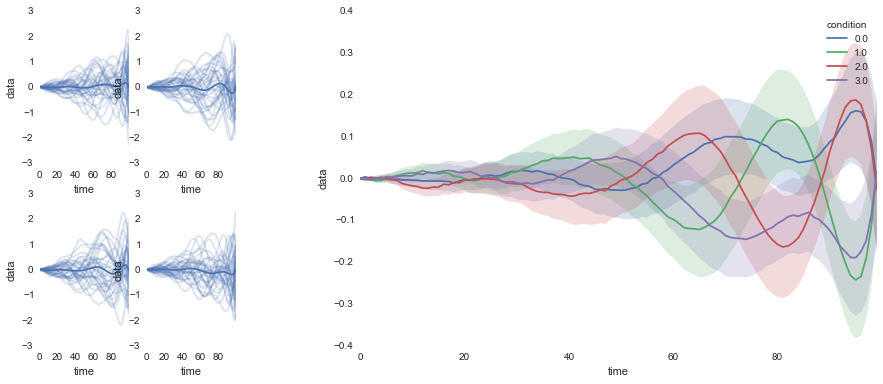

In [4]:
figure(figsize=(15,6))
from matplotlib import gridspec
gs = GridSpec(2,8)
for cond, dfc in df.groupby('condition'):
    subplot(gs[int(cond)/2, mod(int(cond),2)])
    sns.tsplot(dfc.reset_index(), time='time', unit='unit', value='data', err_style='unit_traces')
    ylim([-3, 3])
subplot(gs[:, 3:])
sns.tsplot(df.reset_index(), time='time', unit='unit', value='data', condition='condition')

You can observe two things here: 
First, the individual units are going wild with no clear population response during conditions. Second, if you look at the averages, you can see that I constructed them to be symmetric between individual conditions.

Let's compute the state space analysis and see what we can pull out.

Perform state space analysis
---------------------------

I've implemented the analysis in statespace.py. To do this we need to set up a few things:


In [5]:
'''
The next two variables encode which conditions we are interested in. 
They are somewhat redundant, this will be improved in the future
'''
factors = {'mc':[-1, 1], 'colorc':[-1, 1]}
valid_conditions = [{'mc': -1, 'colorc': -1},
                    {'mc': 1, 'colorc': -1},
                    {'mc': -1, 'colorc': 1},
                    {'mc': 1, 'colorc': 1}]
'''
We also need to define a regression model. This is done by using a 
formula language that you might know from R. What model you use is up to you:
'''
formula = 'mc + colorc +1'

'''
Now we zscore the data and then perform the state space analysis
'''
st.zscore(units)
Q, Bmax, labels, bnt, D, t_bmax, norms, maps = st.embedd(units, formula, valid_conditions)
print labels, Q.shape

Getting regression weights
Doind PCA cleaning
Fitting PCA
Transforming X
Regression embedding
['Intercept', 'mc', 'colorc'] (35, 3)


The matrix Q now contains the orthogonalized dimension vectors that you can use to embed your signal into the lower dimensional space. The dimensionality is: #num units x #num conditions. The labels vector gives the ordering. 

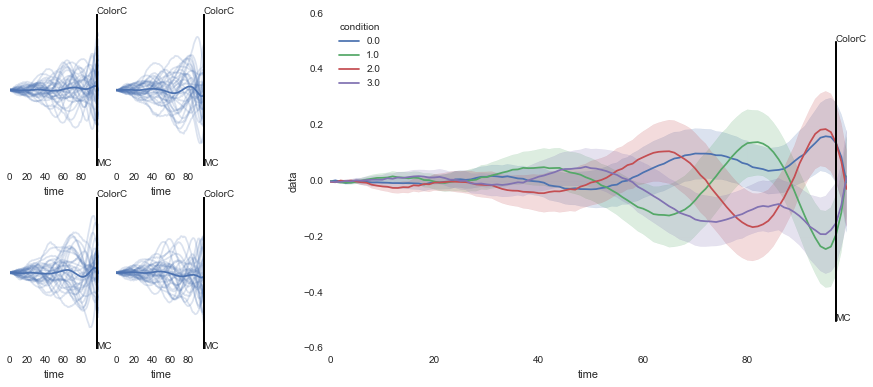

In [6]:
figure(figsize=(15,6))
from matplotlib import gridspec
gs = GridSpec(2,8)
for cond, dfc in df.groupby('condition'):
    subplot(gs[int(cond)/2, mod(int(cond),2)])
    sns.tsplot(dfc.reset_index(), time='time', unit='unit', value='data', err_style='unit_traces')
    ylim([-3, 3])
    plot([t_bmax[2], t_bmax[2]], [-3, 3], 'k')
    text(t_bmax[2], 3, 'ColorC')
    plot([t_bmax[1], t_bmax[1]], [-3, 3], 'k')
    text(t_bmax[1], -3, 'MC')
    yticks([])
    ylabel('')
subplot(gs[:, 3:])
sns.tsplot(df.reset_index(), time='time', unit='unit', value='data', condition='condition')
plot([t_bmax[2], t_bmax[2]], [-0.5, 0.5], 'k')
text(t_bmax[2], 0.5, 'ColorC')
plot([t_bmax[1], t_bmax[1]], [-0.5, 0.5], 'k')
text(t_bmax[1], -0.5, 'MC')


The black line indicates which time point is choosen to define the projection axes. The time point is chosen by looking at the norm of the weight vector for each axis and the maximum norm vector becomes the weight vector for it's axis. Maximum norm implies that the method favors projections in which all channels participate.

Now we can compute the trjaectories in state space during the conditions we are interested. We therefore project the average response to our conditions into the lower dimensional state space.

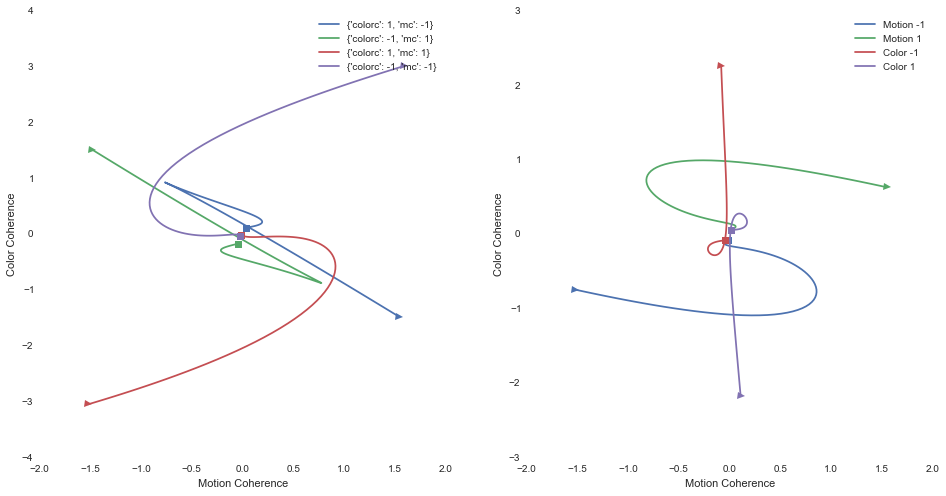

In [7]:
figure(figsize=(16, 8))
subplot(1,2,1)
colors = sns.color_palette()
results = st.get_trajectory(units, factors, Q[:, 1], Q[:, 2])
leg = []
for i, (condition, trajectory) in enumerate(results.iteritems()):
    mc, colorc = trajectory
    leg.append(plot(mc, colorc, color=colors[i])[0])
    plot(mc[0], colorc[0], color=colors[i], marker='s')
    plot(mc[-1], colorc[-1], color=colors[i], marker='>')
xlabel('Motion Coherence')
ylabel('Color Coherence')
legend(leg, results.keys())

subplot(1,2,2)
results = st.get_trajectory(units, {'mc':[-1,1]}, Q[:, 1], Q[:, 2])
leg = []
for i, (condition, trajectory) in enumerate(results.iteritems()):
    mc, colorc = trajectory
    leg.append(plot(mc, colorc, color=colors[i])[0])
    plot(mc[0], colorc[0], color=colors[i], marker='s')
    plot(mc[-1], colorc[-1], color=colors[i], marker='>')
xlabel('Motion Coherence')
ylabel('Color Coherence')

results = st.get_trajectory(units, {'colorc':[-1,1]}, Q[:, 1], Q[:, 2])
for i, (condition, trajectory) in enumerate(results.iteritems()):
    mc, colorc = trajectory
    leg.append(plot(mc, colorc, color=colors[i+2])[0])
    plot(mc[0], colorc[0], color=colors[i+2], marker='s')
    plot(mc[-1], colorc[-1], color=colors[i+2], marker='>')
xlabel('Motion Coherence')
ylabel('Color Coherence')
legend(leg, ['Motion -1', 'Motion 1', 'Color -1', 'Color 1'])

The plot on the left shows the four condition for each combination of conditions, while the plot on the left shows the motion and color coherence condition averaged across the respective other condition.

Example 2: Anne's MEG study
===============

In [10]:
import glob, cPickle, data_anne as da, pandas as pd
w = 655
condition_mapping = {"{'stim_strength': -1, 'response': -1}":'Weak, Rsp. Weak',
                     "{'stim_strength': 1, 'response': 1}":'Strong, Rsp. Strong',
                     "{'stim_strength': -1, 'response': 1}":'Weak, Rsp. Strong',
                     "{'stim_strength': 1, 'response': -1}":'Strong, Rsp. Weak'}
files = glob.glob('*.trajectory')
trj = [(int(f[1:3]), cPickle.load(open(f))) for f in files]
dm, conds = da.tolongform(trj, condition_mapping=condition_mapping, select_samples=lambda x: array(x)[-w:])
df = pd.DataFrame(dict((key, dm.field(key)) for key in dm.fieldnames()))

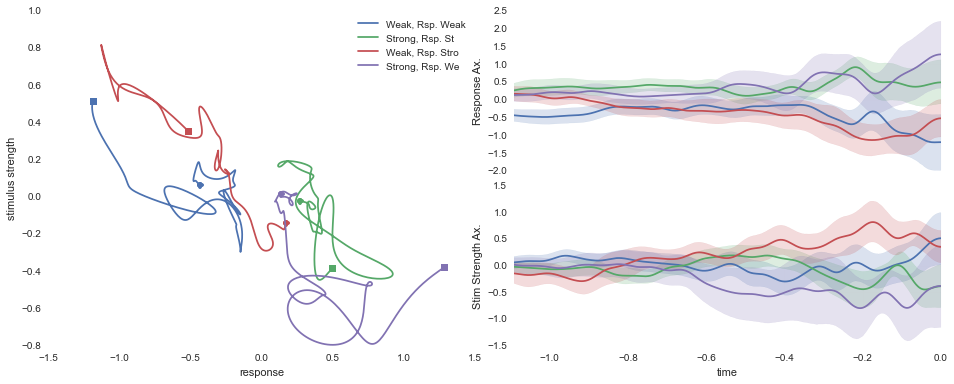

In [38]:
from matplotlib import gridspec
gs = GridSpec(4,4)
figure(figsize=(16,6))
subplot(gs[:, :2])
da.make_2Dplot(df)
subplot(gs[0:2, 2:])
da.make_1Dplot(df, 0)
xticks([])
xlabel('')
ylabel('Response Ax.')
legend([])
subplot(gs[2:, 2:])
da.make_1Dplot(df, 1)
legend([])
ylabel('Stim Strength Ax.')

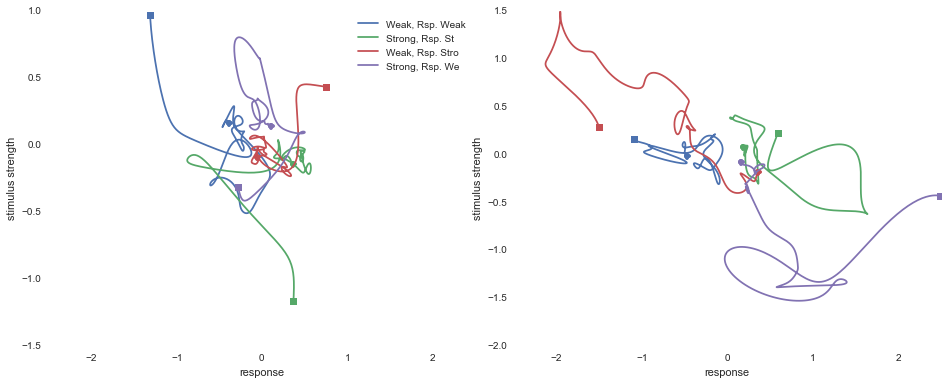

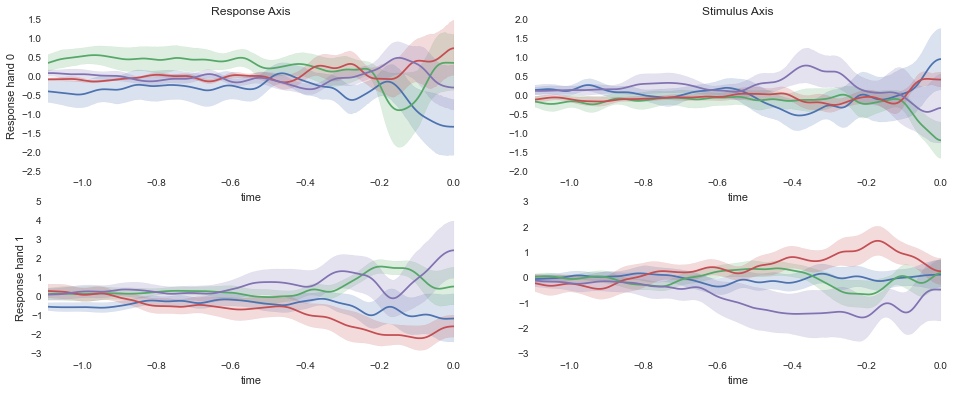

In [46]:
from matplotlib import gridspec
gs = GridSpec(4,4)
figure(figsize=(16,6))
subplot(gs[:, :2])
da.make_2Dplot(df[df.response_hand==0])
xlim([-1.5, 1.5])
xlim([-2.5, 2.5])
subplot(gs[:, 2:])
da.make_2Dplot(df[df.response_hand==1])
legend([])
xlim([-1.5, 1.5])
xlim([-2.5, 2.5])

figure(figsize=(16,6))
gs = GridSpec(2,2)
subplot(gs[0,0])
da.make_1Dplot(df[df.response_hand==0], 0)
title('Response Axis')
ylabel('Response hand 0')
legend([])
subplot(gs[0,1])
title('Stimulus Axis')
da.make_1Dplot(df[df.response_hand==0], 1)
ylabel('')
legend([])
subplot(gs[1,0])
da.make_1Dplot(df[df.response_hand==1], 0)
ylabel('Response hand 1')

legend([])
subplot(gs[1,1])
da.make_1Dplot(df[df.response_hand==1], 1)
ylabel('')
legend([])